In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import os

In [2]:
# data = pd.read_csv('../data/cells/test.csv')
# data.head()

In [3]:
controls = pd.concat([
    pd.read_csv('../data/cells/train_controls.csv'),
    pd.read_csv('../data/cells/test_controls.csv'),
])
controls.head()

,id_code,experiment,plate,well,sirna,well_type
0,HEPG2-01_1_B02,HEPG2-01,1,B02,1138,negative_control
1,HEPG2-01_1_C03,HEPG2-01,1,C03,1109,positive_control
2,HEPG2-01_1_C07,HEPG2-01,1,C07,1121,positive_control
3,HEPG2-01_1_C11,HEPG2-01,1,C11,1126,positive_control
4,HEPG2-01_1_C15,HEPG2-01,1,C15,1118,positive_control


In [4]:
len(controls.groupby(['experiment', 'plate']))

204

In [5]:
controls = controls.iloc[(controls['well_type'] == 'negative_control').values]
len(controls.groupby(['experiment', 'plate']))

204

In [6]:
controls['sirna'].unique()

array([1138])

In [7]:
controls.groupby(['experiment', 'plate'])

In [8]:
s = None
u = controls.groupby(['experiment', 'plate'])['sirna'].unique()

for row in u:
    if s is None:
        s = set(row)
        
    s = s.intersection(row)

# Plate patterns

In [143]:
train = pd.read_csv('../data/cells/train.csv')

# tmp = train.groupby('sirna').plate.unique()
# tmp = tmp.apply(lambda xs: {1, 2, 3, 4}.difference(xs))
# tmp = tmp.apply(lambda xs: list(xs)[0])
# np.save('./ignored.npy', tmp.values)

tmp = train.groupby('sirna').plate.unique()
np.save('./ignored.npy', np.array(list(tmp.values)))

# Plate Stats

In [9]:
# data = pd.read_csv('../data/cells/train_controls.csv')
# print(data.columns)
# data = data[(data['sirna'] == 1138) & (data['well_type'] == 'negative_control')]
# len(data)

In [10]:
# df = pd.merge(data, stats, on=['experiment', 'plate', 'well'], how='inner')
# print(df.columns)
# len(df)

In [11]:
stats = pd.read_csv('../data/cells/pixel_stats.csv')
stats = stats[stats['well'] == 'B02']

In [12]:
res = {}
for (exp, plate, well), group in stats.groupby(['experiment', 'plate', 'well']):
    assert well == 'B02'

    plate_stats = []
    for site, group in group.groupby('site'):
        assert all(group['channel'] == range(1, 7))
        plate_stats.append(group[['mean', 'std']].values)

    k = '{}_{}'.format(exp, plate)
    res[k] = torch.tensor(plate_stats).float() / 255
    assert res[k].size() == (2, 6, 2)
    
assert len(res) == 204

torch.save(res, './plate_stats.pth')

# Transforms

In [13]:
import  torchvision.transforms as T

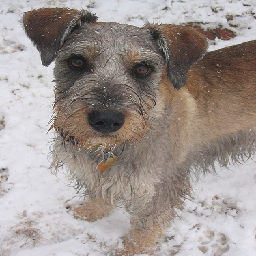

In [14]:
image = Image.open('../imet/sample.jpg')
image = image.resize((256, 256))
image

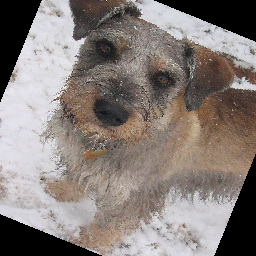

In [15]:
t = T.RandomRotation(360)
t(image)

# Fold Splits

In [16]:
import sys
print(np.__version__)
sys.path.append('../../rxrx1-utils')
import rxrx.io as rio

1.16.3


ModuleNotFoundError: No module named 'rxrx'

In [ ]:
def show_controls(controls):
    for exp, group in controls.groupby('experiment'):
#         if exp[-2:] in ['12', '13', '16', '05', '09', '10', '14', '03', '06', '08', '07', '11', '15']:
#             continue 
            
        print(exp)
        plt.figure(figsize=(14, 3))

        for plate, group in group.groupby('plate'):
            for site in [1, 2]:
                row = group.iloc[0]
                assert row['well'] == 'B02'
                image = rio.load_site(row['subset'], exp, plate, row['well'], site, base_path=row['root'])
                image = rio.convert_tensor_to_rgb(image)
                
                plt.subplot(1, 8, (plate - 1) * 2 + site)
                plt.axis('off')
                plt.title(plate)
                plt.imshow(image)

        plt.tight_layout()
        plt.suptitle(exp)
        plt.show()

root = '../data/cells'

train_controls = pd.read_csv(os.path.join(root, 'train_controls.csv'))
train_controls['subset'] = 'train'

test_controls = pd.read_csv(os.path.join(root, 'test_controls.csv'))
test_controls['subset'] = 'test'

controls = pd.concat([
    train_controls,
#     test_controls,
])
controls['root'] = root
controls['cell_type'] = controls['experiment'].apply(lambda x: x.split('-')[0])
print(controls['cell_type'].unique())

controls = controls[controls['sirna'] == 1138]
controls = controls[controls['cell_type'] == 'U2OS']

show_controls(controls)